## baseline lightning trainer notebook

Created on: Wednesday March 16th, 2022  
Created by: Jacob Alexander Rose  

In [9]:
%load_ext autoreload
%autoreload 2

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "7"


from IPython.display import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import pandas as pd
from pathlib import Path
from icecream import ic
from rich import print as pp
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# from imutils.big.datamodule import Herbarium2022DataModule, Herbarium2022Dataset
from imutils.ml.data.datamodule import Herbarium2022DataModule, Herbarium2022Dataset

from imutils.ml.utils.etl_utils import ETL

import pytorch_lightning as pl
from torchvision import transforms as T
import argparse
from rich import print as pp

import imutils


from hydra.experimental import compose, initialize, initialize_config_dir
import hydra


print(imutils.ml.IMUTILS_ML_ROOT)
print(imutils.ml.BASE_ML_CONF_PATH)

from omegaconf import DictConfig, OmegaConf
from typing import *
default_reader = None
import torchmetrics
# dir(torchmetrics.functional)

from imutils.ml.models.pl import classifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/media/data/jacob/GitHub/image-utils/imutils/ml
/media/data/jacob/GitHub/image-utils/imutils/ml/conf/base_conf.yaml


## Load test config

In [10]:
config_path = os.path.dirname(imutils.ml.BASE_ML_CONF_PATH)
config_name = os.path.basename(imutils.ml.BASE_ML_CONF_PATH)

cfg = ETL.init_structured_config(config_name = config_name,
                                 config_path = config_path,
                                 job_name = "demo",
                                 dataclass_type= None,
                                 overrides = ["data.datamodule.num_workers=4",
                                              # "train.pl_trainer.gpus=4",
                                              "train.pl_trainer.accelerator=gpu",
                                              # "model_cfg.backbone.name=resnet_50"],
                                              "model_cfg.backbone.name=xcit_large_24_p16_224"],
                                              # "model_cfg.backbone.name=resnetv2_101x1_bitm"],
                                             # "model_cfg.backbone.name=resnetv2_50"], 
                                 cfg = None)




/media/data/conda/jrose3/envs/imutils/lib/python3.8/site-packages/hydra/experimental/initialize.py:98: UserWarning: hydra.experimental.initialize_config_dir() is no longer experimental. Use hydra.initialize_config_dir().
  deprecation_warning(
/media/data/conda/jrose3/envs/imutils/lib/python3.8/site-packages/hydra/experimental/compose.py:18: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(


In [11]:
OmegaConf.set_struct(cfg, False)
# Hydra run directory
try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    print(e)
    hydra_dir = os.getcwd()

if not cfg.get("hydra"):
    cfg.update({"hydra":{"run":{"dir":hydra_dir}},
                "run_output_dir":hydra_dir})
    print(cfg.hydra.run.dir)

print(OmegaConf.to_yaml(cfg.hydra))#, resolve=True, sort_keys=True))

name 'HydraConfig' is not defined
/media/data/jacob/GitHub/image-utils/notebooks
run:
  dir: /media/data/jacob/GitHub/image-utils/notebooks



In [12]:
print(OmegaConf.to_yaml(cfg, resolve=True, sort_keys=True))

print(cfg['data']['datamodule']['transform_cfg'])

checkpoint_dir: /media/data/jacob/GitHub/image-utils/notebooks/ckpts
core:
  name: herbarium2022__xcit_large_24_p16_224
  tags:
  - herbarium2022
  - kaggle
  version: 0.0.1
data:
  datamodule:
    _target_: imutils.ml.data.datamodule.Herbarium2022DataModule
    batch_size: 128
    catalog_dir: /media/data/jacob/GitHub/image-utils/imutils/big/data
    datasets:
      herbarium2022:
        test:
          _target_: imutils.ml.data.datamodule.Herbarium2022Dataset
          catalog_dir: /media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize
          label_col: scientificName
          seed: 14
          shuffle: true
          subset: train
          train_size: 0.7
        train:
          _target_: imutils.ml.data.datamodule.Herbarium2022Dataset
          catalog_dir: /media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize
          label_col: scientificName
          seed: 14
          shuffle: true
          subset: train
          tr

In [13]:
type(cfg.model_cfg.input_shape)

omegaconf.listconfig.ListConfig

In [14]:
type(OmegaConf.to_container(cfg.model_cfg.input_shape, resolve=True)[0])

int

## Instantiate experiment ingredients with config

In [15]:
if cfg.train.deterministic:
    pl.seed_everything(cfg.train.random_seed)

if cfg.train.pl_trainer.fast_dev_run:
    hydra.utils.log.info(
        f"Debug mode <{cfg.train.pl_trainer.fast_dev_run}>. "
        f"Forcing debugger friendly configuration!"
    )
    # Debuggers don't like GPUs nor multiprocessing
    cfg.train.pl_trainer.gpus = 0
    cfg.data.datamodule.num_workers.train = 0
    cfg.data.datamodule.num_workers.val = 0
    cfg.data.datamodule.num_workers.test = 0

# Hydra run directory
try:
    hydra_dir = Path(HydraConfig.get().run.dir)
except Exception as e:
    print(e)
    hydra_dir = os.getcwd()

# Instantiate datamodule
hydra.utils.log.info(f"Instantiating <{cfg.data.datamodule._target_}>")
datamodule: pl.LightningDataModule = hydra.utils.instantiate(
    cfg.data.datamodule, _recursive_=False
)

 # cfg=cfg,
datamodule

# Instantiate model
# hydra.utils.log.info(f"Instantiating <{cfg.model_cfg._target_}>")
# model: pl.LightningModule = hydra.utils.instantiate(model_cfg=cfg, _recursive_=False)


from imutils.ml.utils.model_utils import log_model_summary


model = imutils.ml.models.pl.classifier.LitClassifier(cfg=cfg, #model_cfg=cfg.model_cfg,
                                              loss=cfg.model_cfg.loss)

print(OmegaConf.to_yaml(cfg.model_cfg, resolve=True, sort_keys=True))

# input_size = (1, 3,224,224)
# summary = log_model_summary(model=model,
#                             input_size=input_size,
#                             full_summary=True,
#                             working_dir=".",
#                             model_name=cfg.model_cfg.backbone.name,
#                             verbose=1)

from imutils.ml.utils.experiment_utils import configure_callbacks, configure_loggers, configure_trainer

# Instantiate the callbacks
callbacks: List[pl.Callback] = configure_callbacks(cfg=cfg.train) #OmegaConf.to_container(cfg.train, resolve=True))

name 'HydraConfig' is not defined
self.transform_cfg:


{'preprocess': {'train': {'resize': 512}, 'val': {'resize': 256}, 'test': {'resize': 256}}, 
'batch_transform': {'train': {'random_resize_crop': 224}, 'val': {'center_crop': 224}, 
'test': {'center_crop': 224}}, 'normalize': [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]], 
'resolution': 224}

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


Initializing weights of the model head.
input_size: (1, 3, 224, 224)


2022-03-21 10:52:24,221 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pytorch_lightning.callbacks.LearningRateMonitor>
2022-03-21 10:52:24,223 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pytorch_lightning.callbacks.early_stopping.EarlyStopping>
2022-03-21 10:52:24,228 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pytorch_lightning.callbacks.ModelCheckpoint>
2022-03-21 10:52:24,237 imutils.ml.utils.experiment_utils INFO     Instantiating callback <imutils.ml.callbacks.class_label_stats_callbacks.ClassLabelStatsCallback>
2022-03-21 10:52:24,241 imutils.ml.utils.experiment_utils INFO     Instantiating callback <imutils.ml.callbacks.wandb_callbacks.LogPerClassMetricsToWandb>
2022-03-21 10:52:24,243 imutils.ml.utils.experiment_utils INFO     Instantiating callback <pl_bolts.callbacks.ModuleDataMonitor>
2022-03-21 10:52:24,245 imutils.ml.utils.experiment_utils INFO     Instantiating callback <imutils.ml.callbacks.image_stats_ca

Layer (type (var_name):depth-idx)                       Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
Sequential                                              --                        --                        --                        --                        --
├─Sequential (backbone): 1-1                            --                        [1, 3, 224, 224]          [1, 2048, 7, 7]           --                        --
│    └─Conv2d (conv1): 2-1                              [3, 64, 7, 7]             [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     118,013,952
│    └─BatchNorm2d (bn1): 2-2                           [64]                      [1, 64, 112, 112]         [1, 64, 112, 112]         128                       128
│    └─ReLU (act1): 2-3                                 --                        [1, 64, 112, 112]         [1, 64, 112, 112]         --                        --
│    

In [16]:
model.freeze_up_to(layer=-1,
                  submodule="backbone")

Freezing up to layer=-1 in submodule=backbone
Setting to False: conv1.weight
Setting layer:(backbone.conv1.weight) requires_grad=False.
Setting to False: bn1.weight
Setting layer:(backbone.bn1.weight) requires_grad=False.
Setting to False: bn1.bias
Setting layer:(backbone.bn1.bias) requires_grad=False.
Setting to False: layer1.0.conv1.weight
Setting layer:(backbone.layer1.0.conv1.weight) requires_grad=False.
Setting to False: layer1.0.bn1.weight
Setting layer:(backbone.layer1.0.bn1.weight) requires_grad=False.
Setting to False: layer1.0.bn1.bias
Setting layer:(backbone.layer1.0.bn1.bias) requires_grad=False.
Setting to False: layer1.0.conv2.weight
Setting layer:(backbone.layer1.0.conv2.weight) requires_grad=False.
Setting to False: layer1.0.bn2.weight
Setting layer:(backbone.layer1.0.bn2.weight) requires_grad=False.
Setting to False: layer1.0.bn2.bias
Setting layer:(backbone.layer1.0.bn2.bias) requires_grad=False.
Setting to False: layer1.0.conv3.weight
Setting layer:(backbone.layer1.0

In [18]:
# ([(n, p.requires_grad_(False)) for n, p in model.net.backbone.named_parameters()])
pp([(n, p.requires_grad) for n, p in model.net.backbone.named_parameters()])

[
    ('conv1.weight', False),
    ('bn1.weight', False),
    ('bn1.bias', False),
    ('layer1.0.conv1.weight', False),
    ('layer1.0.bn1.weight', False),
    ('layer1.0.bn1.bias', False),
    ('layer1.0.conv2.weight', False),
    ('layer1.0.bn2.weight', False),
    ('layer1.0.bn2.bias', False),
    ('layer1.0.conv3.weight', False),
    ('layer1.0.bn3.weight', False),
    ('layer1.0.bn3.bias', False),
    ('layer1.0.se.fc1.weight', False),
    ('layer1.0.se.fc1.bias', False),
    ('layer1.0.se.fc2.weight', False),
    ('layer1.0.se.fc2.bias', False),
    ('layer1.0.downsample.0.weight', False),
    ('layer1.0.downsample.1.weight', False),
    ('layer1.0.downsample.1.bias', False),
    ('layer1.1.conv1.weight', False),
    ('layer1.1.bn1.weight', False),
    ('layer1.1.bn1.bias', False),
    ('layer1.1.conv2.weight', False),
    ('layer1.1.bn2.weight', False),
    ('layer1.1.bn2.bias', False),
    ('layer1.1.conv3.weight', False),
    ('layer1.1.bn3.weight', False),
    ('layer1.1.bn3.bias', False),
    ('layer1.1.se.fc1.weight', False),
    ('layer1.1.se.fc1.bias', False),
    ('layer1.1.se.fc2.weight', False),
    ('layer1.1.se.fc2.bias', False),
    ('layer1.2.conv1.weight', False),
    ('layer1.2.bn1.weight', False),
    ('layer1.2.bn1.bias', False),
    ('layer1.2.conv2.weight', False),
    ('layer1.2.bn2.weight', False),
    ('layer1.2.bn2.bias', False),
    ('layer1.2.conv3.weight', False),
    ('layer1.2.bn3.weight', False),
    ('layer1.2.bn3.bias', False),
    ('layer1.2.se.fc1.weight', False),
    ('layer1.2.se.fc1.bias', False),
    ('layer1.2.se.fc2.weight', False),
    ('layer1.2.se.fc2.bias', False),
    ('layer2.0.conv1.weight', False),
    ('layer2.0.bn1.weight', False),
    ('layer2.0.bn1.bias', False),
    ('layer2.0.conv2.weight', False),
    ('layer2.0.bn2.weight', False),
    ('layer2.0.bn2.bias', False),
    ('layer2.0.conv3.weight', False),
    ('layer2.0.bn3.weight', False),
    ('layer2.0.bn3.bias', False),
    ('layer2.0.se.fc1.weight', False),
    ('layer2.0.se.fc1.bias', False),
    ('layer2.0.se.fc2.weight', False),
    ('layer2.0.se.fc2.bias', False),
    ('layer2.0.downsample.0.weight', False),
    ('layer2.0.downsample.1.weight', False),
    ('layer2.0.downsample.1.bias', False),
    ('layer2.1.conv1.weight', False),
    ('layer2.1.bn1.weight', False),
    ('layer2.1.bn1.bias', False),
    ('layer2.1.conv2.weight', False),
    ('layer2.1.bn2.weight', False),
    ('layer2.1.bn2.bias', False),
    ('layer2.1.conv3.weight', False),
    ('layer2.1.bn3.weight', False),
    ('layer2.1.bn3.bias', False),
    ('layer2.1.se.fc1.weight', False),
    ('layer2.1.se.fc1.bias', False),
    ('layer2.1.se.fc2.weight', False),
    ('layer2.1.se.fc2.bias', False),
    ('layer2.2.conv1.weight', False),
    ('layer2.2.bn1.weight', False),
    ('layer2.2.bn1.bias', False),
    ('layer2.2.conv2.weight', False),
    ('layer2.2.bn2.weight', False),
    ('layer2.2.bn2.bias', False),
    ('layer2.2.conv3.weight', False),
    ('layer2.2.bn3.weight', False),
    ('layer2.2.bn3.bias', False),
    ('layer2.2.se.fc1.weight', False),
    ('layer2.2.se.fc1.bias', False),
    ('layer2.2.se.fc2.weight', False),
    ('layer2.2.se.fc2.bias', False),
    ('layer2.3.conv1.weight', False),
    ('layer2.3.bn1.weight', False),
    ('layer2.3.bn1.bias', False),
    ('layer2.3.conv2.weight', False),
    ('layer2.3.bn2.weight', False),
    ('layer2.3.bn2.bias', False),
    ('layer2.3.conv3.weight', False),
    ('layer2.3.bn3.weight', False),
    ('layer2.3.bn3.bias', False),
    ('layer2.3.se.fc1.weight', False),
    ('layer2.3.se.fc1.bias', False),
    ('layer2.3.se.fc2.weight', False),
    ('layer2.3.se.fc2.bias', False),
    ('layer3.0.conv1.weight', False),
    ('layer3.0.bn1.weight', False),
    ('layer3.0.bn1.bias', False),
    ('layer3.0.conv2.weight', False),
    ('layer3.0.bn2.weight', False),
    ('layer3.0.bn2.bias', False),
    ('layer3.0.conv3.weight', False),
    ('layer3.0.bn3.weight', False),
    ('layer3.0.bn3.bias', Fal

In [19]:
pp([(n, p.requires_grad) for n, p in model.net.head.named_parameters()])

[('classifier.weight', True), ('classifier.bias', True)]

In [9]:
model.net.head.state_dict().keys()

odict_keys(['classifier.weight', 'classifier.bias'])

In [12]:
model.net["backbone"].state_dict().keys()

TypeError: 'str' object cannot be interpreted as an integer

In [13]:
import pytorch_lightning as pl

pl.__version__

'1.5.0'

In [12]:
4593*8*2*64*2

9406464

In [16]:
587840/64

9185.0

In [17]:
587840/128

4592.5

In [14]:
4593*2

9186

In [9]:
datamodule.setup("fit")

train --> (num_samples: 587,840), (num_batches: 4,593)
val --> (num_samples: 251,932), (num_batches: 1,969)


In [ ]:


train --> (num_samples: 587,840), (num_batches: 9,185)
train --> (num_samples: 587,840), (num_batches: 9,185)
val --> (num_samples: 251,932), (num_batches: 3,937)
val --> (num_samples: 251,932), (num_batches: 3,937)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


In [13]:
val_loader = datamodule.val_dataloader()

batch = next(iter(val_loader))

len(batch)

import torch
from torch import nn
# Single-label categorical
x = torch.randn(10, 5)
y = torch.randint(5, (10,))
loss = nn.CrossEntropyLoss()(x, y)


print(x.shape, y.shape, loss.shape)
print(x.dtype, y.dtype, loss.dtype)

# model

training dataset length: 587840
validation dataset length: 251932


3

torch.Size([10, 5]) torch.Size([10]) torch.Size([])
torch.float32 torch.int64 torch.float32


In [18]:
num_samples = len(datamodule.train_dataset)
num_batches = len(datamodule.train_dataloader())

ic(num_samples, num_batches, num_samples/ num_batches)

import numpy as np

ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?


(587840, 4593, 127.98606575223165)

In [5]:
print(f"{2264842/2:,}")

1,132,421.0


In [7]:
print(f"{2264842/3:,}")

754,947.3333333334


In [19]:
ic(num_samples * np.arange(5))

ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?


array([      0,  587840, 1175680, 1763520, 2351360])

In [10]:
x, y = batch[:2]
print(x.shape, y.shape)
print(x.dtype, y.dtype)
# model

torch.Size([128, 3, 224, 224]) torch.Size([128])
torch.float32 torch.int64


In [15]:
x, y = batch[:2]
logits = model(x)

loss = nn.CrossEntropyLoss()(logits, y)
print(logits.shape, logits.dtype)
print(loss.shape, loss.dtype)

torch.Size([128, 15501]) torch.float32
torch.Size([]) torch.float32


In [2]:
from icecream import ic

In [3]:
a = {0, 8}
ic(a)

ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?


{0, 8}

In [37]:
datamodule.transform_cfg

datamodule.setup_transforms(datamodule.transform_cfg)

In [46]:
# datamodule.setup_transforms(datamodule.transform_cfg)
from imutils.ml.data.datamodule import get_default_transforms

a = get_default_transforms(mode="train", config=datamodule.transform_cfg)

a

self.normalize: [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]


Compose(
    Preprocess(
  (resize_func): Resize(size=512, interpolation=bilinear)
)
    BatchTransform(
  (transforms): Sequential(
    (0): RandomPerspective(p=0.5)
    (1): RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    (2): RandomHorizontalFlip(p=0.5)
    (3): RandomVerticalFlip(p=0.5)
    (4): Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  )
)
)

In [41]:
datamodule.train_dataset.transform

In [38]:
datamodule.train_transform

In [13]:
batch[0].shape

torch.Size([128, 960, 960, 3])

In [33]:
batch[0].shape

torch.Size([128, 960, 960, 3])

In [11]:
# datamodule.setup("fit")
datamodule.train_dataset.df

,index,Species,path,y,category_id,genus_id,institution_id,image_id,file_name,license,scientificName,family,genus,species,authors,collectionCode
0,800061,Trifolium fucatum,/media/data_cifs/projects/prj_fossils/data/raw...,14752,14756,2443,36,14756__047,147/56/14756__047.jpg,0,Trifolium fucatum Lindl.,Fabaceae,Trifolium,fucatum,Lindl.,NY
1,294940,Eragrostis urbaniana,/media/data_cifs/projects/prj_fossils/data/raw...,5484,5486,895,36,05486__011,054/86/05486__011.jpg,0,Eragrostis urbaniana Hitchc.,Poaceae,Eragrostis,urbaniana,Hitchc.,NY
2,546499,Osmorhiza purpurea,/media/data_cifs/projects/prj_fossils/data/raw...,10087,10091,1726,24,10091__046,100/91/10091__046.jpg,0,Osmorhiza purpurea (J.M.Coult. & Rose) Suksd.,Apiaceae,Osmorhiza,purpurea,(J.M.Coult. & Rose) Suksd.,ID
3,162934,Castilleja minor,/media/data_cifs/projects/prj_fossils/data/raw...,3088,3090,446,25,03090__061,030/90/03090__061.jpg,0,Castilleja minor (A.Gray) A.Gray,Orobanchaceae,Castilleja,minor,(A.Gray) A.Gray,IDS
4,206860,Corchorus hirsutus,/media/data_cifs/projects/prj_fossils/data/raw...,3894,3896,624,36,03896__020,038/96/03896__020.jpg,0,Corchorus hirsutus L.,Malvaceae,Corchorus,hirsutus,L.,NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587835,189517,Cirsium wheeleri,/media/data_cifs/projects/prj_fossils/data/raw...,3586,3588,550,51,03588__060,035/88/03588__060.jpg,0,Cirsium wheeleri Petr.,Asteraceae,Cirsium,wheeleri,Petr.,UNM
587836,174412,Cestrum parqui,/media/data_cifs/projects/prj_fossils/data/raw...,3307,3309,483,52,03309__061,033/09/03309__061.jpg,0,Cestrum parqui (Lam.) L'Hér.,Solanaceae,Cestrum,parqui,(Lam.) L'Hér.,US
587837,49177,Aralia hispida,/media/data_cifs/projects/prj_fossils/data/raw...,958,959,174,52,00959__054,009/59/00959__054.jpg,0,Aralia hispida Vent.,Araliaceae,Aralia,hispida,Vent.,US
587838,84389,Astragalus tetrapterus,/media/data_cifs/projects/prj_fossils/data/raw...,1628,1629,219,36,01629__043,016/29/01629__043.jpg,0,Astragalus tetrapterus A.Gray,Fabaceae,Astragalus,tetrapterus,A.Gray,NY


In [12]:
import wandb

def configure_loggers(cfg):

    wandb_logger = None
    if "wandb" in cfg.logging:
        hydra.utils.log.info(f"Instantiating <WandbLogger>")
        wandb_config = cfg.logging.wandb
        wandb_logger = pl.loggers.WandbLogger(
            name=wandb_config
            .get("name", 
                           (cfg.data.datamodule.get("name") + "__" + cfg.model_cfg.name)),
            project=wandb_config.project,
            entity=wandb_config.entity,
            tags=cfg.core.tags,
            log_model=True,
        )
        hydra.utils.log.info(f"W&B is now watching <{wandb_config.watch.log}>!")
        wandb_logger.watch(
            model, log=wandb_config.watch.log, log_freq=wandb_config.watch.log_freq
        )


        hydra.utils.log.info(f"Instantiating the Trainer")
    return wandb_logger

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jrose (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [5]:
wandb_logger = configure_loggers(cfg=cfg, model=model)
print(wandb_logger)

NameError: name 'configure_loggers' is not defined

In [13]:
# The Lightning core, the Trainer
trainer = pl.Trainer(
    default_root_dir=cfg.hydra.run.dir,
    logger=wandb_logger,
    callbacks=callbacks,
    deterministic=cfg.train.deterministic,
    val_check_interval=cfg.logging.val_check_interval,
    log_every_n_steps=10,
    #auto_select_gpus=True,
    # benchmark=True,
    # accelerator=None,  # 'dp', "ddp" if args.gpus > 1 else None,
    #plugins=[DDPPlugin(find_unused_parameters=True)],
    **cfg.train.pl_trainer,
)

# num_samples = len(datamodule.train_dataset)
num_classes = cfg.model_cfg.head.num_classes
batch_size = datamodule.batch_size #["train"]

hydra.utils.log.info("Starting training with {} classes and batches of {} images".format(
    num_classes,
    batch_size))

/media/data/conda/jrose3/envs/imutils/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:286: LightningDeprecationWarning: Passing `Trainer(accelerator='dp')` has been deprecated in v1.5 and will be removed in v1.7. Use `Trainer(strategy='dp')` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [14]:
# pp(OmegaConf.to_container(cfg.train.callbacks, resolve=True))

training dataset length: 587840


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


validation dataset length: 251932


{
    '_target_': 'torch.optim.Adam',
    'lr': 0.001,
    'betas': [0.9, 0.999],
    'eps': 1e-08,
    'weight_decay': 0.0
}

AttributeError: 'NoneType' object has no attribute 'df'

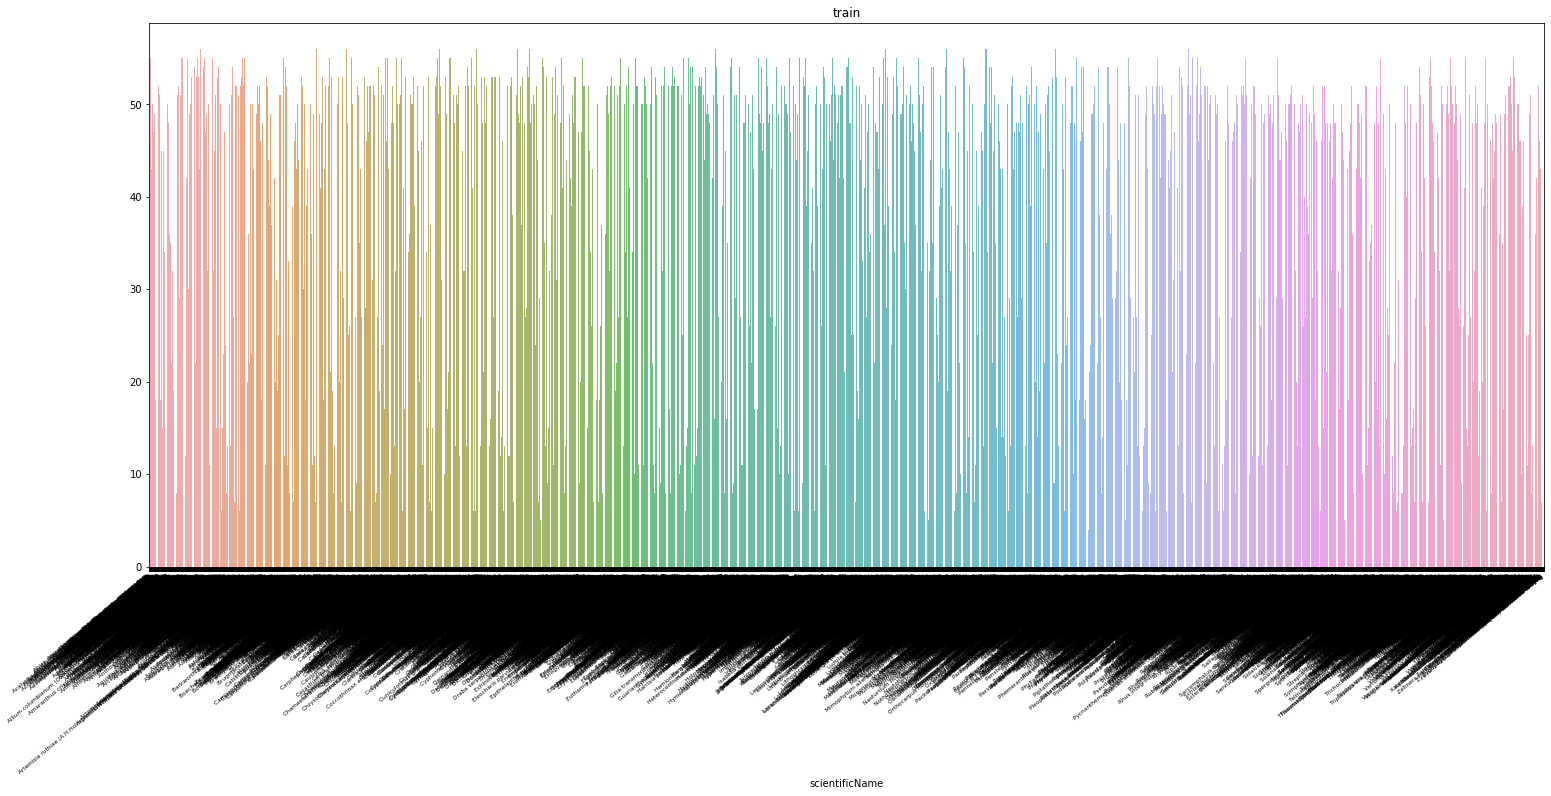

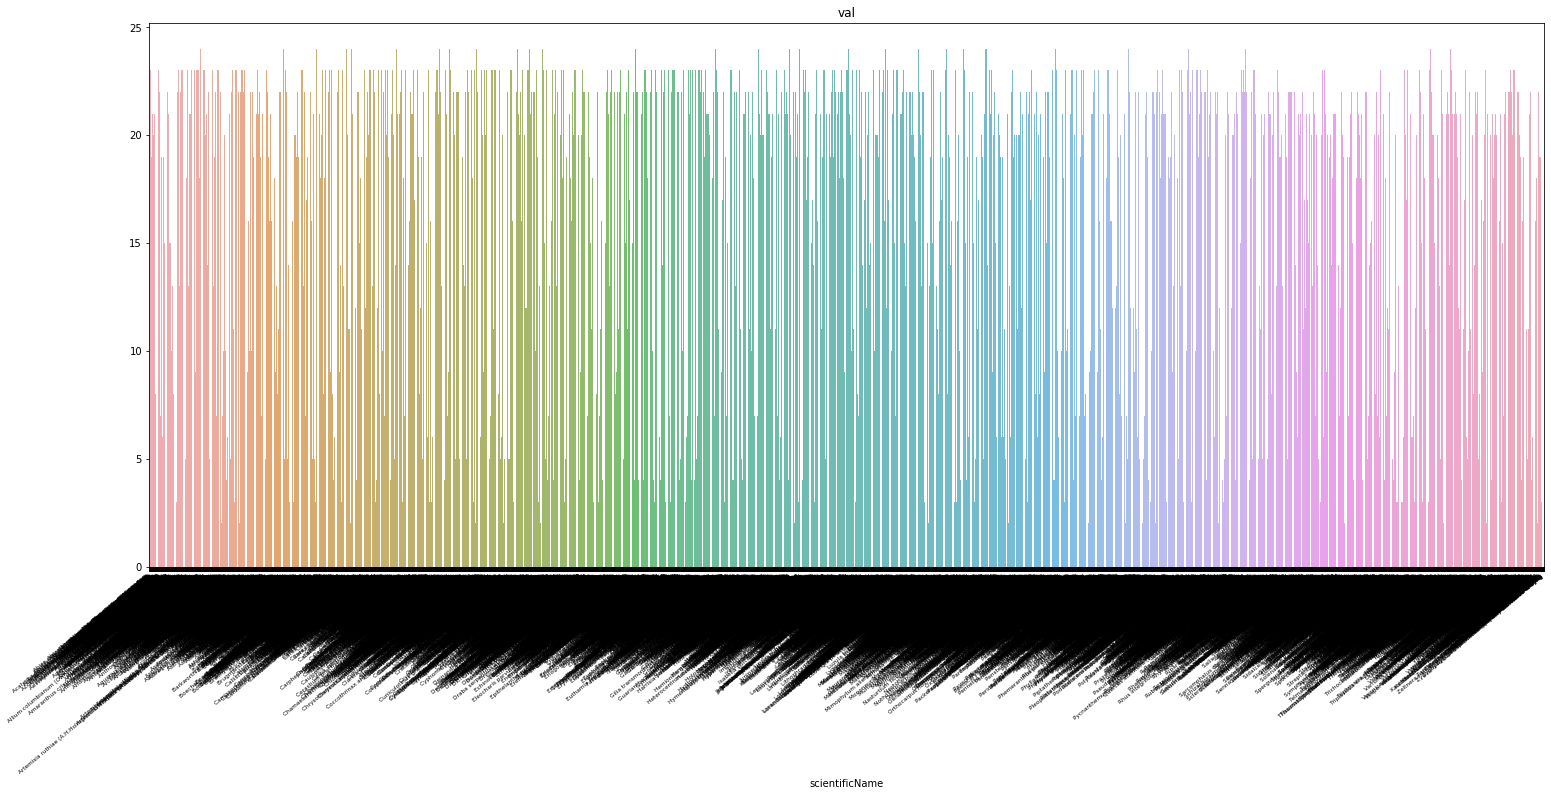

In [15]:
trainer.fit(model=model, datamodule=datamodule)

In [ ]:


#%debug

In [ ]:
hydra.utils.log.info(f"Starting testing!")
trainer.test(model=model, datamodule=datamodule)

shutil.copytree(".hydra", Path(wandb_logger.experiment.dir) / "hydra")

In [22]:

def measure_time(func):
    def wrapper(*args, **kwargs):
        from time import time
        start = time()
        result = func(*args, **kwargs)
        total_time = time() - start
        print(f'Elapsed time is {total_time} ms')
        
        if isinstance(result, int):
            print(f"{result}/{total_time} = {result/(total_time):.3f} samples/sec")
        return result
    return wrapper



In [23]:


from tqdm import tqdm

@measure_time
def loop_through_dataloader(dataloader, num_batches):
    data_iter = iter(dataloader)
    for i, batch in tqdm(enumerate(data_iter), total=num_batches):
        if i > num_batches-1:
            break
    num_samples = i*len(batch[0])
    return num_samples



# train_iter = iter(datamodule.train_dataloader())
datamodule.setup()
dataloader = datamodule.train_dataloader()
num_batches = 40


loop_through_dataloader(dataloader, num_batches)

/media/data/conda/jrose3/envs/imutils/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [01:00<00:00,  1.51s/it]


Elapsed time is 71.13705635070801 ms
5120/71.13705635070801 = 71.974 samples/sec


5120

In [21]:
# bb = next(iter(dataloader))

In [13]:
# pp(datamodule.cfg)
pp(OmegaConf.to_container(datamodule.cfg))

{
    'catalog_dir': 
'/media/data_cifs/projects/prj_fossils/data/raw_data/herbarium-2022-fgvc9_resize',
    'label_col': 'scientificName',
    'train_size': 0.7,
    'shuffle': True,
    'seed': 14,
    'batch_size': 128,
    'num_workers': 4,
    'pin_memory': True,
    'transform_cfg': {
        'preprocess': {
            'train': {'resize': 512},
            'val': {'resize': 256},
            'test': {'resize': 256}
        },
        'batch_transform': {
            'train': {'random_resize_crop': 224},
            'val': {'center_crop': 224},
            'test': {'center_crop': 224}
        },
        'normalize': [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]
    },
    'remove_transforms': False
}

In [11]:
type(datamodule.cfg)

omegaconf.dictconfig.DictConfig

In [4]:

# default_cfg = DictConfig(dict(
#     catalog_dir=None,
#     label_col="scientificName",
#     train_size=0.7,
#     shuffle=True,
#     seed=14,
#     batch_size = 128,
#     num_workers = None,
#     pin_memory=True,
#     transform_cfg=None,
#     remove_transforms=False,
# ))

# from rich import print as pp

# pp(OmegaConf.to_yaml(default_cfg))

### Mock config yaml

In [59]:
CATALOG_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/catalog"

datamodule = Herbarium2022DataModule(catalog_dir=CATALOG_DIR,
                                     num_workers=4,
                                     # image_reader=read_file_binary,
                                     remove_transforms=True)
datamodule.setup()

In [60]:
subset = "train"
dataset = datamodule.get_dataset(subset=subset)

In [102]:
dataset.num_classes

15501

In [ ]:
trainer.fit(model, datamodule)

## End

In [6]:
# from torchvision import transforms as T
# import argparse
# from rich import print as pp

# args = argparse.Namespace(
#     preprocess={
#         "train":{
#             "resize":512
#         },
#         "val":{
#             "resize":256
#         },
#     },
#     batch_transform={
#         "train":{
#             "random_resize_crop":224
#         },
#         "val":{
#             "center_crop":224
#         },
#     normalize=(
#        [0.485, 0.456, 0.406],
#        [0.229, 0.224, 0.225]
#     )
#     }
# )
# pp(args)

Namespace(batch_transform={'train': {'random_resize_crop': 224}, 'val': {'center_crop': 
224}}, preprocess={'train': {'resize': 512}, 'val': {'resize': 256}})

In [ ]:
# kornia_transform = nn.Sequential(
#     K.RandomHorizontalFlip(),
#     K.RandomVerticalFlip(),
#     K.RandomMotionBlur(3, 35., 0.5),
#     K.RandomRotation(degrees=45.0),
#     K.Normalize(mean=mean_std,std=mean_std)
# )

In [15]:
# import numpy as np
# from torch import nn
# import torch
# from albumentations.augmentations import transforms as AT

# to_tensor = T.ToTensor()

# class Preprocess(nn.Module):

#     def __init__(self, mode="train", resize=None):
#         super().__init__()
#         self.mode = mode
#         self.resize = resize        
#         self.resize_func = T.Resize(self.resize)
    
#     @torch.no_grad()  # disable gradients for effiency
#     def forward(self, x) -> torch.Tensor:
#         # x_tmp: np.ndarray = np.array(x)  # HxWxC
#         # x_out: Tensor = to_tensor(x_tmp, keepdim=True)  # CxHxW
#         if self.resize:
#             x = self.resize_func(x)

#         return x #_out.float()# / 255.0




# class BatchTransforms(nn.Module):
#     """Module to perform data augmentation using Kornia on torch tensors."""

#     def __init__(self,
#                  mode: str="train",
#                  random_resize_crop=None,
#                  center_crop=None,
#                  apply_color_jitter: bool = False,
#                  normalize = (
#                      [0,0,0],
#                      [1,1,1]
#                  )
#                 ) -> None:
#         super().__init__()
#         self.mode = mode
#         self.random_resize_crop = random_resize_crop
#         self.center_crop = center_crop
#         self._apply_color_jitter = apply_color_jitter
#         self.normalize = normalize
        
#         self.build_transforms(mode=mode)

        
#     def add_train_transforms(self, transforms=None):
        
#         transforms = transforms or []
#         # if mode == "train":
#         transforms.append(T.RandomPerspective())
#         if type(self.random_resize_crop) == int:
#             transforms.append(T.RandomResizedCrop(self.random_resize_crop))
#         transforms.extend([
#             T.RandomHorizontalFlip(),
#             T.RandomVerticalFlip()
#         ])
#         return transforms

#     def add_test_transforms(self, transforms=None):
        
#         transforms = transforms or []
#         if type(self.center_crop) == int:
#             transforms.append(T.CenterCrop(self.center_crop))
#         return transforms


#     def build_transforms(self,
#                          mode: str = "train"):
#         transforms = []
#         if mode == "train":
#             transforms = self.add_train_transforms(transforms=transforms)
#         elif mode in ["val", "test"]:
#             transforms = self.add_test_transforms(transforms=transforms)

#         transforms.extend([
# 			# T.ToTensor(),
# 			T.Normalize(*self.normalize)
#         ])

#         self.transforms = nn.Sequential(*transforms)
#         self.jitter = AT.ColorJitter(brightness=0.2,
#                                      contrast=0.2,
#                                      saturation=0.2,
#                                      hue=0.2,
#                                      always_apply=False,
#                                      p=0.5)

#     @torch.no_grad()  # disable gradients for effiency
#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         x_out = self.transforms(x)  # BxCxHxW
#         if self._apply_color_jitter:
#             x_out = self.jitter(x_out)
#         return x_out

In [3]:
# for subset in ["train","val", "test"]:
#     data = Herbarium2022Dataset(subset=subset,
#                                 label_col="scientificName",
#                                 train_size=0.7,
#                                 shuffle=(subset != "test"),
#                                 seed=14,
#                                 transform=None)

#########################################

CATALOG_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/catalog"
SHARD_DIR = "/media/data_cifs/projects/prj_fossils/users/jacob/data/herbarium_2022/webdataset"

# datamodule = Herbarium2022DataModule(catalog_dir=CATALOG_DIR,
#                                      batch_size=64,
#                                      num_workers=4,
#                                      image_reader=read_file_binary,
#                                      remove_transforms=True)
# datamodule.setup()


# train_dataloader = datamodule.train_dataloader()
# train_batch = next(iter(train_dataloader))
# datamodule.train_dataset.encoder.inverse_transform(train_batch[1])

In [ ]:
# checkpoint_callback = [c for c in callbacks if isinstance(c, pl.callbacks.ModelCheckpoint)][0]
# logging.info(f"checkpoint_callback.best_model_path: {str(checkpoint_callback.best_model_path)}")
# config.system.tasks[f"task_{task_id}"].ckpt_path = checkpoint_callback.best_model_path
# checkpoint_callback.best_model_score = checkpoint_callback.best_model_score or 0.0
# logging.info(f"checkpoint_callback.best_model_score: {checkpoint_callback.best_model_score:.3f}")
# logging.info(f"[Initiating TESTING on task_{task_id}]")


# test_results = run_multitask_test(trainer=trainer,
#                               model=model,
#                               datamodule=datamodule,
#                               config=config,
#                               tasks="all")#,